
4422102/4422102 [==============================] - 1s 0us/step


Epoch 1/5


63/63 [==============================] - 1s 3ms/step - loss: 1.6509 - accuracy: 0.4615 - val_loss: 0.9725 - val_accuracy: 0.7050
Epoch 2/5
63/63 [==============================] - 0s 2ms/step - loss: 0.8352 - accuracy: 0.7530 - val_loss: 0.8090 - val_accuracy: 0.7100
Epoch 3/5
63/63 [==============================] - 0s 1ms/step - loss: 0.6095 - accuracy: 0.8315 - val_loss: 0.6753 - val_accuracy: 0.7600
Epoch 4/5
63/63 [==============================] - 0s 1ms/step - loss: 0.4755 - accuracy: 0.8755 - val_loss: 0.6267 - val_accuracy: 0.7700
Epoch 5/5
63/63 [==============================] - 0s 1ms/step - loss: 0.3883 - accuracy: 0.8990 - val_loss: 0.6407 - val_accuracy: 0.7550

Adversarially Trained Model Accuracy: 75.50%
Epoch 1/5
32/32 [==============================] - 0s 6ms/step - loss: 1.4986 - accuracy: 0.5150 - val_loss: 0.9396 - val_accuracy: 0.6700
Epoch 2/5
32/32 [==============================] - 0

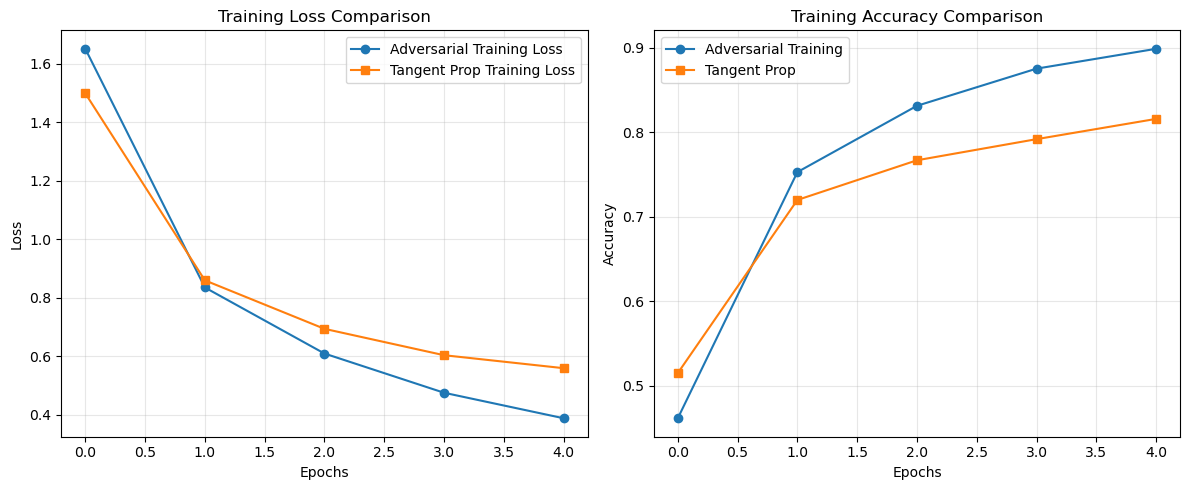


Adversarial Training Accuracy: 75.50%
Tangent Prop Accuracy: 76.00%
Tangent Distance Classifier: 77.50%


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Layer
import matplotlib.pyplot as plt
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

subset_size = 1000
x_train = x_train[:subset_size] / 255.0
y_train = y_train[:subset_size]
x_test = x_test[:200] / 255.0
y_test = y_test[:200]

def create_model():
    model = Sequential([
        Flatten(input_shape=(28, 28)),
        Dense(64, activation='relu'),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer='adam',
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def generate_adversarial_examples(model, x, y, epsilon=0.1):
    x_tensor = tf.convert_to_tensor(x, dtype=tf.float32)
    y_tensor = tf.convert_to_tensor(y, dtype=tf.int64)
    with tf.GradientTape() as tape:
        tape.watch(x_tensor)
        predictions = model(x_tensor, training=False)
        loss = tf.keras.losses.sparse_categorical_crossentropy(y_tensor, predictions)
    gradient = tape.gradient(loss, x_tensor)
    signed_grad = tf.sign(gradient)
    x_adv = x_tensor + epsilon * signed_grad
    x_adv = tf.clip_by_value(x_adv, 0.0, 1.0)
    return x_adv.numpy()

model_adv = create_model()
x_adv = generate_adversarial_examples(model_adv, x_train, y_train, epsilon=0.1)
x_combined = np.concatenate([x_train, x_adv])
y_combined = np.concatenate([y_train, y_train])

history_adv = model_adv.fit(x_combined, y_combined, epochs=5,
                            validation_data=(x_test, y_test), verbose=1)

loss_adv, accuracy_adv = model_adv.evaluate(x_test, y_test, verbose=0)
print(f'\nAdversarially Trained Model Accuracy: {accuracy_adv * 100:.2f}%')

class TangentProp(Layer):
    def call(self, x):
        perturbation = tf.random.normal(shape=tf.shape(x), stddev=0.1)
        return x + perturbation

model_tangent_prop = Sequential([
    Flatten(input_shape=(28, 28)),
    TangentProp(),
    Dense(64, activation='relu'),
    Dense(10, activation='softmax')
])
model_tangent_prop.compile(optimizer='adam',
                           loss='sparse_categorical_crossentropy',
                           metrics=['accuracy'])

history_tangent_prop = model_tangent_prop.fit(x_train, y_train,
                                              epochs=5,
                                              validation_data=(x_test, y_test),
                                              verbose=1)

loss_tangent_prop, accuracy_tangent_prop = model_tangent_prop.evaluate(x_test, y_test, verbose=0)
print(f'\nTangent Propagation Model Accuracy: {accuracy_tangent_prop * 100:.2f}%')

def tangent_distance(x1, x2):
    return np.linalg.norm(x1 - x2)

def classify_with_tangent_distance(x_train, y_train, x_test):
    x_train_flat = x_train.reshape(x_train.shape[0], -1)
    x_test_flat = x_test.reshape(x_test.shape[0], -1)
    y_pred = []
    print(f"\nClassifying {len(x_test_flat)} test samples...")
    for i, test_sample in enumerate(x_test_flat):
        if (i + 1) % 20 == 0:
            print(f"Progress: {i + 1}/{len(x_test_flat)}")
        distances = [tangent_distance(test_sample, train_sample)
                     for train_sample in x_train_flat]
        nearest_index = np.argmin(distances)
        y_pred.append(y_train[nearest_index])
    return np.array(y_pred)

y_pred_tangent = classify_with_tangent_distance(x_train, y_train, x_test)
accuracy_tangent = np.mean(y_pred_tangent == y_test)
print(f'\nTangent Distance Classifier Accuracy: {accuracy_tangent * 100:.2f}%')

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_adv.history['loss'], label='Adversarial Training Loss', marker='o')
plt.plot(history_tangent_prop.history['loss'], label='Tangent Prop Training Loss', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.plot(history_adv.history['accuracy'], label='Adversarial Training', marker='o')
plt.plot(history_tangent_prop.history['accuracy'], label='Tangent Prop', marker='s')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training Accuracy Comparison')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nAdversarial Training Accuracy: {accuracy_adv * 100:.2f}%")
print(f"Tangent Prop Accuracy: {accuracy_tangent_prop * 100:.2f}%")
print(f"Tangent Distance Classifier: {accuracy_tangent * 100:.2f}%")
